# Processing results using BigQuery #

We start by importing all the requisite packages from BayesCMD etc. as well as ones required to plot and read data from big query.

In [1]:
import os
import argparse
from pathlib import Path
import json
import matplotlib.pyplot as plt
from distutils import dir_util
from pprint import pprint
import pickle

# BayesCMD packages 
from bayescmd.results_handling import kde_plot
from bayescmd.results_handling import scatter_dist_plot
from bayescmd.results_handling import data_import
from bayescmd.results_handling import plot_repeated_outputs
from bayescmd.results_handling import histogram_plot
from bayescmd.results_handling import data_merge_by_batch
from bayescmd.abc import import_actual_data
from bayescmd.abc import priors_creator

# Google BigQuery
from google.cloud import bigquery
%load_ext google.cloud.bigquery

STARTING AT: /home/buck06191/repos/Github/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/Github/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/Github/BayesCMD/bayescmd
 Looking for: BayesCMD


In [2]:
# Explicitly use service account credentials by specifying the private
# key file. All clients in google-cloud-python have this helper.
client = bigquery.Client.from_service_account_json(
    "../../gcloud/hypothermia-auth.json"
)

In [3]:
def generate_histogram_query(project, dataset, model, n_bins, distance):
    histogram_query = """
    SELECT
      MIN(data.{distance}) AS min,
      MAX(data.{distance}) AS max,
      COUNT(data.{distance}) AS num,
      INTEGER((data.{distance}-value.min)/(value.max-value.min)*{n_bins}) AS group_
    FROM
      [{project}:{dataset}.{model}] data
    CROSS JOIN (
      SELECT
        MAX({distance}) AS max,
        MIN({distance}) AS min
      FROM
        [{project}:{dataset}.{model}]) value
    GROUP BY
      group_
    ORDER BY
      group_
    """.format(dataset=dataset, model=model, n_bins=n_bins, distance=distance, project=project)
    return histogram_query

In [4]:
def generate_posterior_query(project, dataset, model, distance, parameters, limit=50000):
    unpacked_params = ",\n".join(parameters)
    histogram_query = """
SELECT
    {unpacked_params},
    {distance},
    idx
FROM
  `{project}.{dataset}.{model}`
ORDER BY
  {distance} ASC
LIMIT
  {limit}
    """.format(project=project, dataset=dataset, model=model, unpacked_params=unpacked_params,distance=distance, limit=limit)
    return histogram_query

In [5]:
def load_configuration(model_version, dataset, verbose=False):
    current_file = Path(os.path.abspath(''))
    config_file = os.path.join(current_file.parents[2],
                              'config_files',
                               'abc',
                               'bp_hypothermia_{}'.format(model_version),
                               'bp_hypothermia_{}_config.json'.format(model_version)
                              )

    with open(config_file, 'r') as conf_f:
        conf = json.load(conf_f)

    params = conf['priors']

    input_path = os.path.join(current_file.parents[2],
                              'data',
                              'clean_hypothermia',
                              '{}_filtered_formatted.csv'.format(dataset.upper()))

    d0 = import_actual_data(input_path)

    targets = conf['targets']
    model_name = conf['model_name']
    inputs = conf['inputs']

    config = {
        "model_name": model_name,
        "targets": targets,
        "inputs": inputs,
        "parameters": params,
        "input_path": input_path,
        "zero_flag": conf['zero_flag'],
    }
    
    if verbose:
        pprint(config)
        
    return config, d0

In [7]:
configuration = {}
for model_number in ["1_1", "2_1", "4_1"]:
    model_name = 'bph{}'.format(model_number)
    configuration[model_name] = {}
    for DATASET in ['LWP479']:
        configuration[model_name][DATASET] = {}
        config, d0 = load_configuration(model_number, DATASET)
        configuration[model_name][DATASET]['bayescmd_config'] = config
        configuration[model_name][DATASET]['original_data']= d0
        
        configuration[model_name][DATASET]['histogram_query'] = generate_histogram_query('hypothermia-bayescmd', 
                                                                                            DATASET, 
                                                                                            model_name, 
                                                                                            100, 
                                                                                            'NRMSE')
        
        configuration[model_name][DATASET]['posterior_query'] = generate_posterior_query('hypothermia-bayescmd', 
                                                                                            DATASET, 
                                                                                            model_name, 
                                                                                            'NRMSE', 
                                                                                            list(configuration[model_name][DATASET]['bayescmd_config']['parameters'].keys()))


Working on bph1_1 - LWP479


/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/buck06191/repos/Github/BayesCMD/bayescmd/results_handling.py:544: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sorted_df['Accepted'][sorted_df[d] == 100000] = 2
/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Sample 0, idx:3910
{'CBFn': 0.007862185060699212,
 'K_sigma': 9.591373192276917,
 'NADpool': 3.7384469802952425,
 'O2_n': 0.025295771111128785,
 'Q_10': 0.13900791782420652,
 'R_auto': 2.111871632281642,
 'Xtot_n': 4.9994801343062,
 'k_aut': 0.9065180847382788,
 'n_h': 2.465248632467424,
 'phi': 0.03967089084410205,
 'r_0': 0.011843901301271952,
 'r_n': 0.01732931185383455,
 'r_t': 0.018308999534916204}
Sample 1, idx:3713
{'CBFn': 0.006962564011623954,
 'K_sigma': 10.446223554684083,
 'NADpool': 3.4207115930609637,
 'O2_n': 0.027071544366289117,
 'Q_10': 0.15636302147682346,
 'R_auto': 2.5482197791231007,
 'Xtot_n': 5.483327722991325,
 'k_aut': 0.840217941162874,
 'n_h': 2.1232412568980967,
 'phi': 0.03714702561888099,
 'r_0': 0.0147771670005244,
 'r_n': 0.01904736725396651,
 'r_t': 0.01906416291618613}
Sample 2, idx:2513
{'CBFn': 0.008747222184948809,
 'K_sigma': 9.492639363038911,
 'NADpool': 4.040873265878024,
 'O2_n': 0.022776863160177768,
 'Q_10': 0.15077349293901546,
 'R_auto': 2

Sample 21, idx:4180
{'CBFn': 0.0064497880249937975,
 'K_sigma': 9.121958755950317,
 'NADpool': 2.7652113474007987,
 'O2_n': 0.028374697861685776,
 'Q_10': 0.2969239500925374,
 'R_auto': 2.5610297007093616,
 'Xtot_n': 7.977367186868666,
 'k_aut': 0.9858133948832446,
 'n_h': 2.2240765131358406,
 'phi': 0.041027875766404896,
 'r_0': 0.01218562314879895,
 'r_n': 0.016604601519450694,
 'r_t': 0.019556983948604046}
Sample 22, idx:2772
{'CBFn': 0.007549353795030952,
 'K_sigma': 9.269463791906864,
 'NADpool': 4.390918391934192,
 'O2_n': 0.025502654098262287,
 'Q_10': 0.11363564269501812,
 'R_auto': 2.332196610760019,
 'Xtot_n': 5.229073295197137,
 'k_aut': 0.7701864234109079,
 'n_h': 2.9872269273736167,
 'phi': 0.030711789770880894,
 'r_0': 0.014119615330424185,
 'r_n': 0.016280657457551598,
 'r_t': 0.01743438276116936}
Sample 23, idx:4010
{'CBFn': 0.007134450882780617,
 'K_sigma': 10.078241876006217,
 'NADpool': 3.929280449059634,
 'O2_n': 0.021306929103344845,
 'Q_10': 0.12004371813444532,
 

Sample 41, idx:1627
{'CBFn': 0.008914952706821059,
 'K_sigma': 11.162135361597146,
 'NADpool': 2.9132339579795064,
 'O2_n': 0.025902033204856057,
 'Q_10': 0.11281658954737644,
 'R_auto': 2.0873384705475257,
 'Xtot_n': 4.249529179021653,
 'k_aut': 0.9161788229644432,
 'n_h': 2.323481076876357,
 'phi': 0.030745876072774025,
 'r_0': 0.014163493238062094,
 'r_n': 0.015463937694515954,
 'r_t': 0.019011752170608454}
Sample 42, idx:4515
{'CBFn': 0.006645679878378358,
 'K_sigma': 8.593006021058471,
 'NADpool': 3.900461811951345,
 'O2_n': 0.02461205266346578,
 'Q_10': 0.276069839345833,
 'R_auto': 4.303020650311957,
 'Xtot_n': 4.242730373387419,
 'k_aut': 0.9208778293954638,
 'n_h': 2.7479298025918157,
 'phi': 0.03748372405269272,
 'r_0': 0.01408005681849011,
 'r_n': 0.015510410461908881,
 'r_t': 0.01958226223493741}
Sample 43, idx:587
{'CBFn': 0.0068136911419422715,
 'K_sigma': 9.814815734090773,
 'NADpool': 4.0457352702023845,
 'O2_n': 0.02107530777258796,
 'Q_10': 0.15187192915955672,
 'R_au

Sample 62, idx:4004
{'CBFn': 0.00664422471480972,
 'K_sigma': 8.92964946609419,
 'NADpool': 3.4335754673004817,
 'O2_n': 0.026479718185501502,
 'Q_10': 0.07746166116445187,
 'R_auto': 1.7489212066552784,
 'Xtot_n': 6.412121152433064,
 'k_aut': 0.8612250941889378,
 'n_h': 2.263541229713504,
 'phi': 0.03131517581936678,
 'r_0': 0.012587548270028816,
 'r_n': 0.018531904505635084,
 'r_t': 0.01803985115375543}
Sample 63, idx:348
{'CBFn': 0.007427149619787075,
 'K_sigma': 11.061095948967886,
 'NADpool': 3.0825938111331643,
 'O2_n': 0.02557354394938489,
 'Q_10': 0.13850818862967787,
 'R_auto': 0.6831682727675448,
 'Xtot_n': 4.2126961027042595,
 'k_aut': 0.9861929838341216,
 'n_h': 2.013660099588241,
 'phi': 0.0418909739884144,
 'r_0': 0.014567444894036531,
 'r_n': 0.0207253931728503,
 'r_t': 0.01871093757124445}
Sample 64, idx:2256
{'CBFn': 0.007243345232151347,
 'K_sigma': 8.212973148447276,
 'NADpool': 4.260605414374607,
 'O2_n': 0.022797568647668118,
 'Q_10': 0.09760426094821552,
 'R_auto'

Sample 83, idx:1001
{'CBFn': 0.00805057186509049,
 'K_sigma': 9.005259265230979,
 'NADpool': 3.9522810596269884,
 'O2_n': 0.024858796810093557,
 'Q_10': 0.17755030203513475,
 'R_auto': 2.1357793135885164,
 'Xtot_n': 5.971031944995781,
 'k_aut': 0.980303341363516,
 'n_h': 2.7892349754024144,
 'phi': 0.032073970245889066,
 'r_0': 0.014947596864714209,
 'r_n': 0.016720101327708056,
 'r_t': 0.01962138189756618}
Sample 84, idx:2503
{'CBFn': 0.0070631775164871485,
 'K_sigma': 8.84975620248116,
 'NADpool': 3.6444136789887054,
 'O2_n': 0.02163143880157108,
 'Q_10': 0.2442187688827771,
 'R_auto': 2.4343253416357715,
 'Xtot_n': 5.704985708364746,
 'k_aut': 0.9306132624566664,
 'n_h': 2.4927989109080184,
 'phi': 0.035795445458716886,
 'r_0': 0.014347749350856882,
 'r_n': 0.02050266196941265,
 'r_t': 0.01976714838994752}
Sample 85, idx:2811
{'CBFn': 0.008032581340344541,
 'K_sigma': 9.996133325119727,
 'NADpool': 3.8950777223223936,
 'O2_n': 0.024771958624118986,
 'Q_10': 0.18195621595767367,
 'R_

/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/buck06191/repos/Github/BayesCMD/bayescmd/results_handling.py:544: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sorted_df['Accepted'][sorted_df[d] == 100000] = 2
/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Sample 0, idx:4456
{'K_sigma': 8.039289834704956,
 'NADpool': 3.071999863411588,
 'Q_10_haemo': 0.4230088710587444,
 'Q_10_met': 0.0930733273552353,
 'Xtot_n': 5.587593374203007,
 '_L0n': 0.8417499480978822,
 'a_frac_n': 0.8884181504935459,
 'pH_mn': 7.3003082975022755,
 'phi': 0.043137314794814564,
 'r_0': 0.01097655505722392,
 'r_n': 0.01817610904341636}
Sample 1, idx:3005
{'K_sigma': 11.317581739397864,
 'NADpool': 3.173444079982195,
 'Q_10_haemo': 5.922250899088148,
 'Q_10_met': 0.1023675916787556,
 'Xtot_n': 3.8520955012518323,
 '_L0n': 0.8406346119777826,
 'a_frac_n': 0.5488921260614525,
 'pH_mn': 7.483250951013735,
 'phi': 0.04128007815366025,
 'r_0': 0.012788758715266812,
 'r_n': 0.01820105348906643}
Sample 2, idx:2460
{'K_sigma': 9.383812853395805,
 'NADpool': 3.333334440063167,
 'Q_10_haemo': 5.7598942806012525,
 'Q_10_met': 0.07921771639229311,
 'Xtot_n': 4.641369071951669,
 '_L0n': 2.0504781819457145,
 'a_frac_n': 0.6701573790956825,
 'pH_mn': 7.5994849444896655,
 'phi': 0.

Sample 23, idx:1308
{'K_sigma': 11.013097079559298,
 'NADpool': 3.343984560651319,
 'Q_10_haemo': 5.9359550661970655,
 'Q_10_met': 0.22053459540845832,
 'Xtot_n': 6.807830944037219,
 '_L0n': 2.7480360559950445,
 'a_frac_n': 0.1745280828257182,
 'pH_mn': 7.337417706760303,
 'phi': 0.033125026427740865,
 'r_0': 0.011707621831177751,
 'r_n': 0.01698879039093306}
Sample 24, idx:3931
{'K_sigma': 8.967486256831894,
 'NADpool': 3.1320245635864317,
 'Q_10_haemo': 4.627868741764984,
 'Q_10_met': 0.1627291261515863,
 'Xtot_n': 4.140283383558243,
 '_L0n': 0.8767237309867305,
 'a_frac_n': 0.30667024940966203,
 'pH_mn': 7.3944128852113,
 'phi': 0.04191151464640574,
 'r_0': 0.011694343532716986,
 'r_n': 0.018055346212789983}
Sample 25, idx:4625
{'K_sigma': 9.094807053427992,
 'NADpool': 3.5578196652084646,
 'Q_10_haemo': 3.9156401790746864,
 'Q_10_met': 0.0713766026304335,
 'Xtot_n': 5.457764027383625,
 '_L0n': 1.9517540375525293,
 'a_frac_n': 0.7742882308411164,
 'pH_mn': 7.365505609070853,
 'phi':

Sample 46, idx:691
{'K_sigma': 8.498509817423132,
 'NADpool': 4.04234533158985,
 'Q_10_haemo': 5.667545667674457,
 'Q_10_met': 0.2564129132969572,
 'Xtot_n': 4.289079074557375,
 '_L0n': 3.111849355472049,
 'a_frac_n': 0.15328231149710514,
 'pH_mn': 7.270189125487673,
 'phi': 0.040960241998253134,
 'r_0': 0.011814032849721249,
 'r_n': 0.018907676139751757}
Sample 47, idx:1390
{'K_sigma': 9.97541628794155,
 'NADpool': 3.4051627783778446,
 'Q_10_haemo': 5.897193974939693,
 'Q_10_met': 0.18182291654548866,
 'Xtot_n': 3.665799566342852,
 '_L0n': 0.9172016651368452,
 'a_frac_n': 0.5166610333716711,
 'pH_mn': 7.487402121035607,
 'phi': 0.03977752015552005,
 'r_0': 0.010347911893745345,
 'r_n': 0.015159369748923391}
Sample 48, idx:4675
{'K_sigma': 9.523323175828164,
 'NADpool': 4.452484221134561,
 'Q_10_haemo': 5.163713437333475,
 'Q_10_met': 0.21289690005232528,
 'Xtot_n': 3.965650173866468,
 '_L0n': 4.857517889145095,
 'a_frac_n': 0.2632737099562336,
 'pH_mn': 7.4212715726961385,
 'phi': 0.0

Sample 69, idx:4003
{'K_sigma': 8.928866112867976,
 'NADpool': 3.5558198998669086,
 'Q_10_haemo': 5.488799657504231,
 'Q_10_met': 0.18060755000156545,
 'Xtot_n': 5.839674523422224,
 '_L0n': 3.9282080867105535,
 'a_frac_n': 0.37167716654218574,
 'pH_mn': 7.505655509243343,
 'phi': 0.03754719996645784,
 'r_0': 0.011186714427308866,
 'r_n': 0.017781908273844474}
Sample 70, idx:1505
{'K_sigma': 8.825088504313904,
 'NADpool': 4.057772818511372,
 'Q_10_haemo': 3.718150197004258,
 'Q_10_met': 0.15191695475991535,
 'Xtot_n': 5.255553656103758,
 '_L0n': 0.8285381448649282,
 'a_frac_n': 0.4122703201097214,
 'pH_mn': 7.395667721993817,
 'phi': 0.04121020630755304,
 'r_0': 0.012079250805395887,
 'r_n': 0.019084329385979367}
Sample 71, idx:3803
{'K_sigma': 9.427508269134783,
 'NADpool': 3.7105158793065174,
 'Q_10_haemo': 4.660269073970602,
 'Q_10_met': 0.2305922131147397,
 'Xtot_n': 7.715678297527938,
 '_L0n': 3.2923899000409667,
 'a_frac_n': 0.03992724324813501,
 'pH_mn': 7.289532857271928,
 'phi'

Sample 92, idx:3753
{'K_sigma': 11.285518061437385,
 'NADpool': 3.0445419039904045,
 'Q_10_haemo': 5.262425346733336,
 'Q_10_met': 0.17835537150366745,
 'Xtot_n': 3.908826155272235,
 '_L0n': 2.345273309029776,
 'a_frac_n': 0.3539441719055494,
 'pH_mn': 7.372492929462375,
 'phi': 0.04124987949127873,
 'r_0': 0.012013176309694092,
 'r_n': 0.016929407002650398}
Sample 93, idx:4479
{'K_sigma': 11.292214953388989,
 'NADpool': 3.6748614187188697,
 'Q_10_haemo': 4.25727169577702,
 'Q_10_met': 0.13405612567864594,
 'Xtot_n': 5.3828252845790185,
 '_L0n': 2.7632874179708486,
 'a_frac_n': 0.5309736774393725,
 'pH_mn': 7.586103077872129,
 'phi': 0.03919780491970962,
 'r_0': 0.011052479906798671,
 'r_n': 0.015428014329537968}
Sample 94, idx:153
{'K_sigma': 10.975964824055932,
 'NADpool': 3.897128515054856,
 'Q_10_haemo': 4.799827817682988,
 'Q_10_met': 0.13427699684520816,
 'Xtot_n': 4.837436460708684,
 '_L0n': 3.800772554785041,
 'a_frac_n': 0.3701973222583996,
 'pH_mn': 7.352713079759719,
 'phi':

/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/buck06191/repos/Github/BayesCMD/bayescmd/results_handling.py:544: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sorted_df['Accepted'][sorted_df[d] == 100000] = 2
/home/buck06191/virtualenvs/bayescmd/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Sample 0, idx:3265
{'CBFn': 0.007016860127488504,
 'CMRO2_n': 0.01819146368384081,
 'NADpool': 4.213038137620358,
 'Q_10': 0.07945866196865094,
 'Xtot_n': 3.6694992382582567,
 '_L0n': 0.800982656370321,
 'k_aut': 0.7828330056722862,
 'pH_on': 7.06064349574069,
 'phi': 0.03410292694831989,
 'q_diff': 0.5162787459828319,
 'r_0': 0.01247408915949152,
 'r_n': 0.01497446791687445,
 'r_t': 0.016751451239669764}
Sample 1, idx:923
{'CBFn': 0.0071614189076047935,
 'CMRO2_n': 0.02129230677568393,
 'NADpool': 4.050901209888576,
 'Q_10': 0.1218011051141612,
 'Xtot_n': 3.8641902368676764,
 '_L0n': 2.2691408671857025,
 'k_aut': 0.699923593073536,
 'pH_on': 6.834392222264628,
 'phi': 0.03510157357877508,
 'q_diff': 0.8761162202065221,
 'r_0': 0.012934322151678343,
 'r_n': 0.016687467704148088,
 'r_t': 0.015770629512021413}
Sample 2, idx:615
{'CBFn': 0.00886443549039744,
 'CMRO2_n': 0.018935702033407803,
 'NADpool': 3.04454647952869,
 'Q_10': 0.0755762940759976,
 'Xtot_n': 6.025199600507817,
 '_L0n': 

Sample 20, idx:4198
{'CBFn': 0.009356012582846868,
 'CMRO2_n': 0.02166914432291857,
 'NADpool': 3.21715225242972,
 'Q_10': 0.14185300262229672,
 'Xtot_n': 4.240591048067232,
 '_L0n': 3.5059888057504707,
 'k_aut': 0.6818728891057758,
 'pH_on': 7.004814188436207,
 'phi': 0.03970792809124405,
 'q_diff': 0.6706608366625354,
 'r_0': 0.014612804418246209,
 'r_n': 0.017805199861881883,
 'r_t': 0.01662952467530326}
Sample 21, idx:4509
{'CBFn': 0.008516667453781414,
 'CMRO2_n': 0.018332117068995245,
 'NADpool': 3.5104127313201183,
 'Q_10': 0.10540747455446484,
 'Xtot_n': 3.9907336031291365,
 '_L0n': 3.0211349624390316,
 'k_aut': 0.5958015677128273,
 'pH_on': 7.138297507025879,
 'phi': 0.042366301850079585,
 'q_diff': 0.6648604062996789,
 'r_0': 0.012600436207409286,
 'r_n': 0.01512216530818158,
 'r_t': 0.015001111185131932}
Sample 22, idx:3258
{'CBFn': 0.006926434380324554,
 'CMRO2_n': 0.02096036824035944,
 'NADpool': 3.923668597059375,
 'Q_10': 0.15450432411261425,
 'Xtot_n': 7.571674818789897

Sample 40, idx:1949
{'CBFn': 0.008985729197007316,
 'CMRO2_n': 0.020691497889548015,
 'NADpool': 3.3213400225319054,
 'Q_10': 0.058673143190934265,
 'Xtot_n': 5.936243737079617,
 '_L0n': 1.5726192964271255,
 'k_aut': 0.9421080273580934,
 'pH_on': 7.004563821126959,
 'phi': 0.03872725752877049,
 'q_diff': 0.8727914729568732,
 'r_0': 0.01390531144492564,
 'r_n': 0.016382399690644266,
 'r_t': 0.01910697630071644}
Sample 41, idx:1837
{'CBFn': 0.007173977279368378,
 'CMRO2_n': 0.02073744063734316,
 'NADpool': 3.776439412135925,
 'Q_10': 0.13454562999037692,
 'Xtot_n': 4.3779578764120695,
 '_L0n': 3.877057628263397,
 'k_aut': 0.9896654923415872,
 'pH_on': 7.147286157314758,
 'phi': 0.029282297091949887,
 'q_diff': 0.5158483098229915,
 'r_0': 0.0123022967392408,
 'r_n': 0.01667967443517455,
 'r_t': 0.01920561374277144}
Sample 42, idx:1726
{'CBFn': 0.006736203751042942,
 'CMRO2_n': 0.022252251968472424,
 'NADpool': 4.301346511128887,
 'Q_10': 0.15611726262070533,
 'Xtot_n': 7.0344937524632165,

Sample 60, idx:3844
{'CBFn': 0.009572365329054032,
 'CMRO2_n': 0.01646274654978789,
 'NADpool': 3.1758151706661724,
 'Q_10': 0.07899588594820989,
 'Xtot_n': 4.281450497646601,
 '_L0n': 2.682860505316334,
 'k_aut': 0.7190496082923251,
 'pH_on': 6.876380944197235,
 'phi': 0.03452169402929008,
 'q_diff': 0.9820628329462344,
 'r_0': 0.014044296736138884,
 'r_n': 0.01622656977073504,
 'r_t': 0.01704630788852324}
Sample 61, idx:828
{'CBFn': 0.007427485493986577,
 'CMRO2_n': 0.022655395711917475,
 'NADpool': 3.8929410159331423,
 'Q_10': 0.18500313040469868,
 'Xtot_n': 6.378655032448047,
 '_L0n': 3.2684236091672187,
 'k_aut': 0.9695717776130972,
 'pH_on': 7.008011875377729,
 'phi': 0.03650485947774584,
 'q_diff': 0.9812732156849948,
 'r_0': 0.014889371546974653,
 'r_n': 0.01618957591060944,
 'r_t': 0.019502887390532242}
Sample 62, idx:111
{'CBFn': 0.007531592881142239,
 'CMRO2_n': 0.018764313657112282,
 'NADpool': 2.7806771576685696,
 'Q_10': 0.08339282591772755,
 'Xtot_n': 7.900231513525849,


Sample 80, idx:82
{'CBFn': 0.0075598109502833626,
 'CMRO2_n': 0.02341596331850131,
 'NADpool': 3.0130434077651094,
 'Q_10': 0.08719289571293566,
 'Xtot_n': 6.033626726872423,
 '_L0n': 1.4802632474730568,
 'k_aut': 0.9236856303155024,
 'pH_on': 7.15489111764014,
 'phi': 0.03994744935320818,
 'q_diff': 0.6286107133698006,
 'r_0': 0.01110509717574276,
 'r_n': 0.015528226375147763,
 'r_t': 0.018416397192602088}
Sample 81, idx:1316
{'CBFn': 0.007343715588141655,
 'CMRO2_n': 0.02195549516551977,
 'NADpool': 3.2721996713805352,
 'Q_10': 0.13383867313428727,
 'Xtot_n': 5.5396154002535685,
 '_L0n': 1.3907552565066517,
 'k_aut': 0.7193306066466668,
 'pH_on': 7.160184405087698,
 'phi': 0.04155712632750005,
 'q_diff': 0.7166614555932018,
 'r_0': 0.01357892791453681,
 'r_n': 0.01895336251871195,
 'r_t': 0.016164242680913026}
Sample 82, idx:2905
{'CBFn': 0.009116445559553977,
 'CMRO2_n': 0.018147092005769774,
 'NADpool': 3.4762522220154954,
 'Q_10': 0.07862918945582624,
 'Xtot_n': 5.436816848038907,

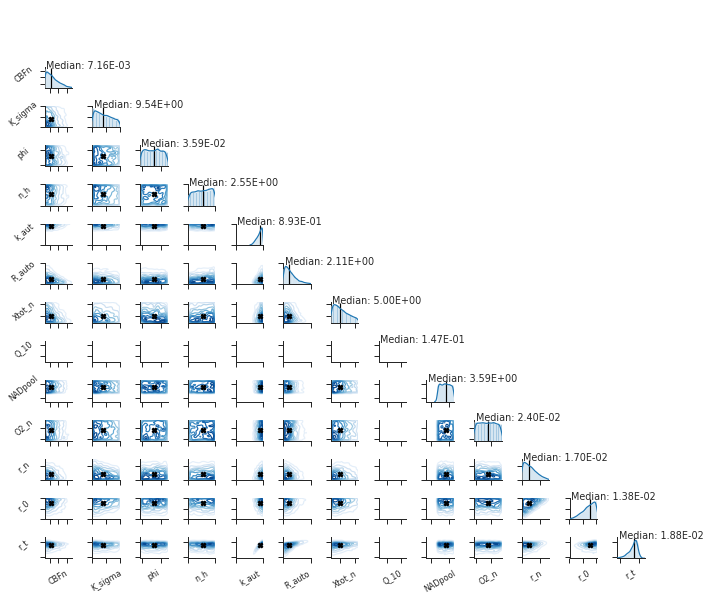

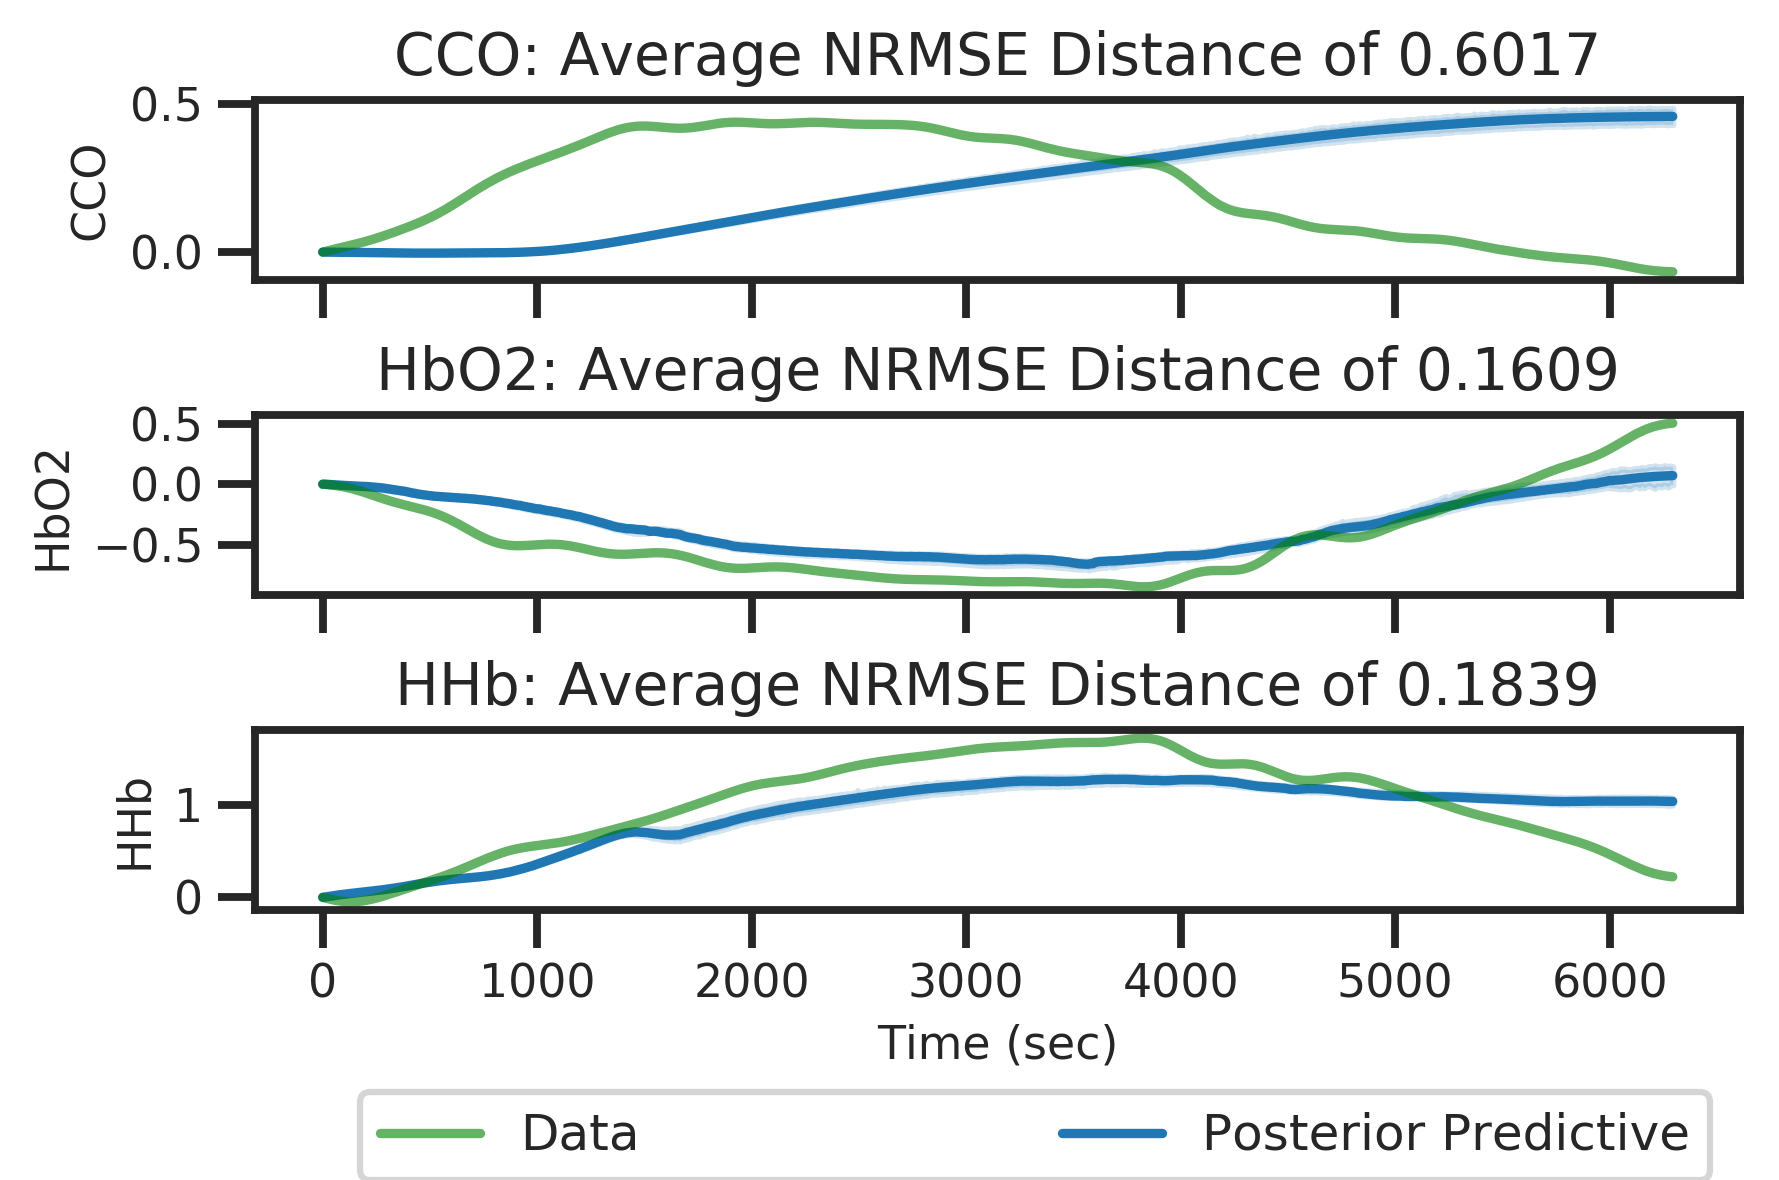

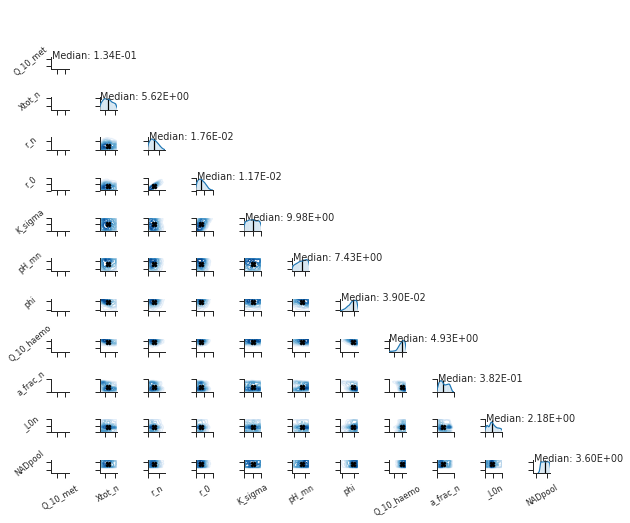

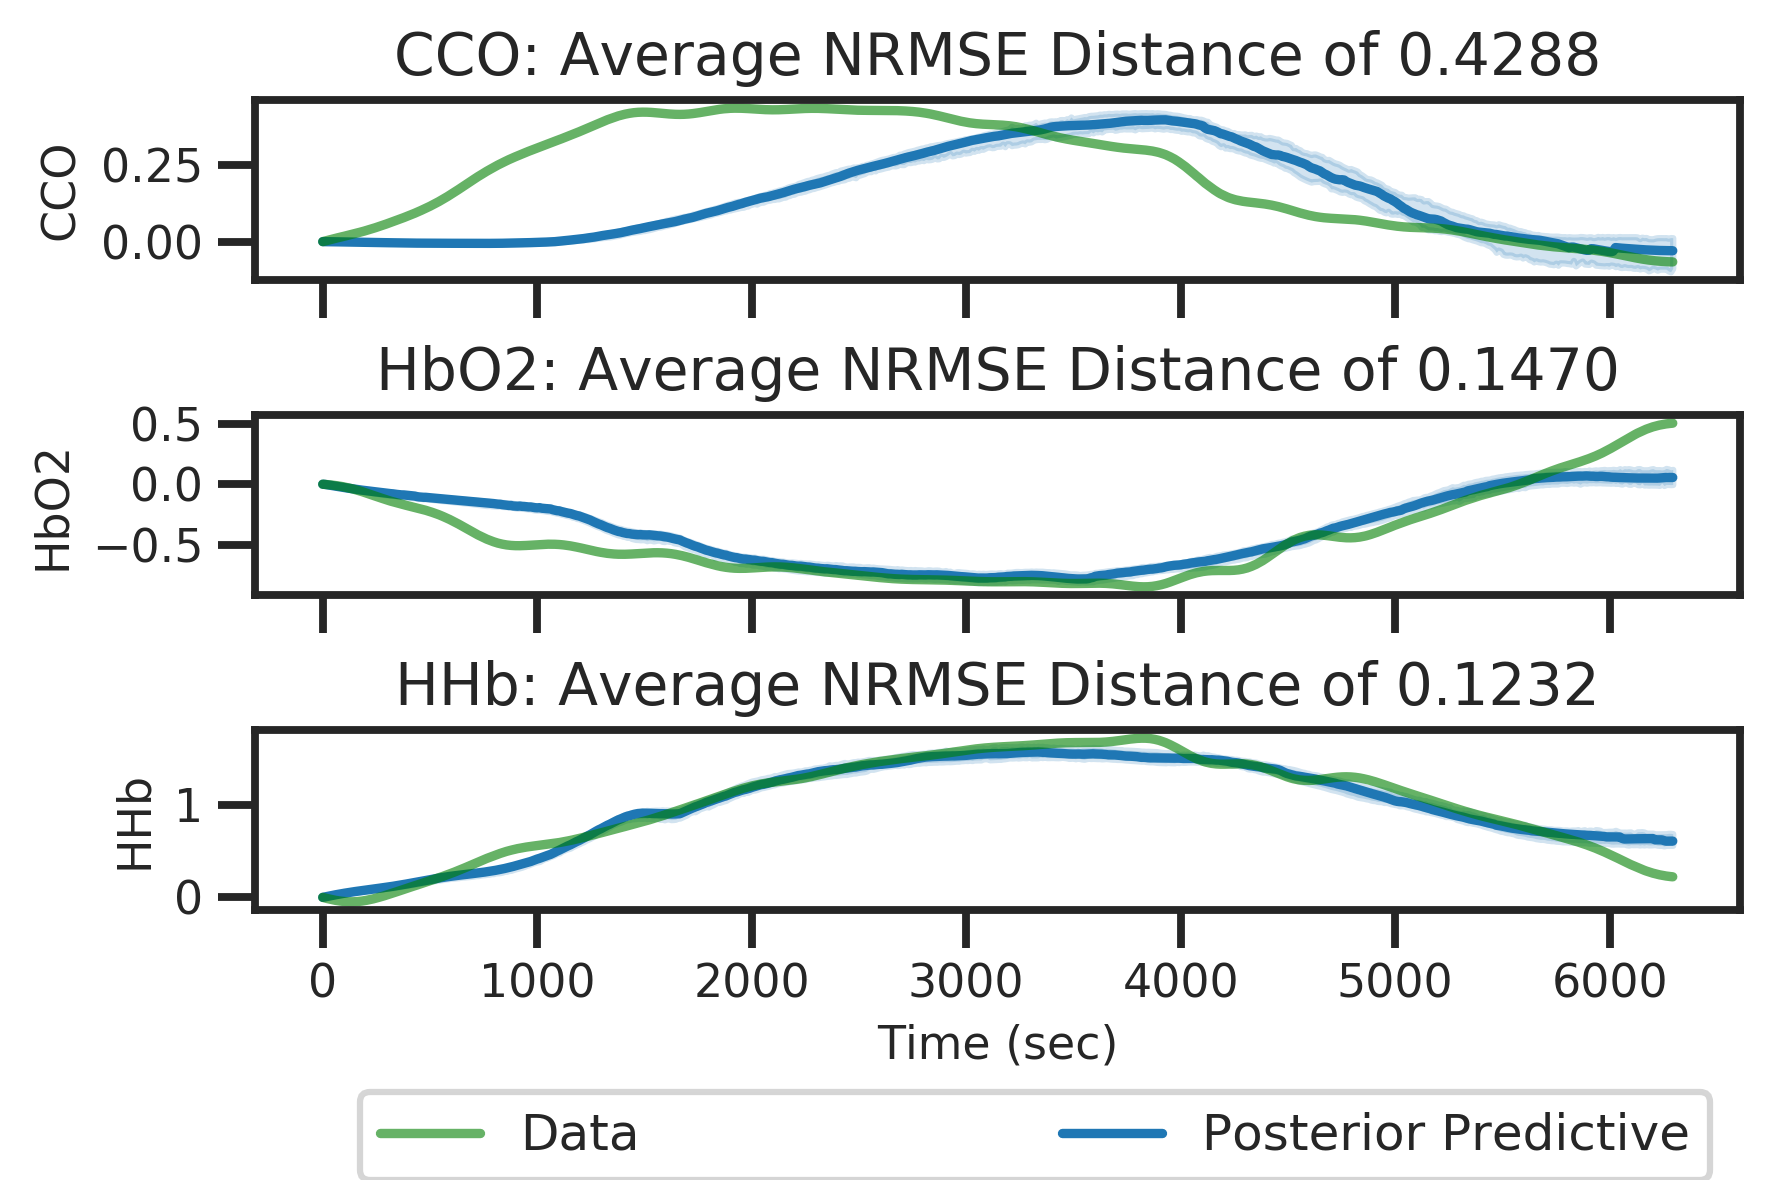

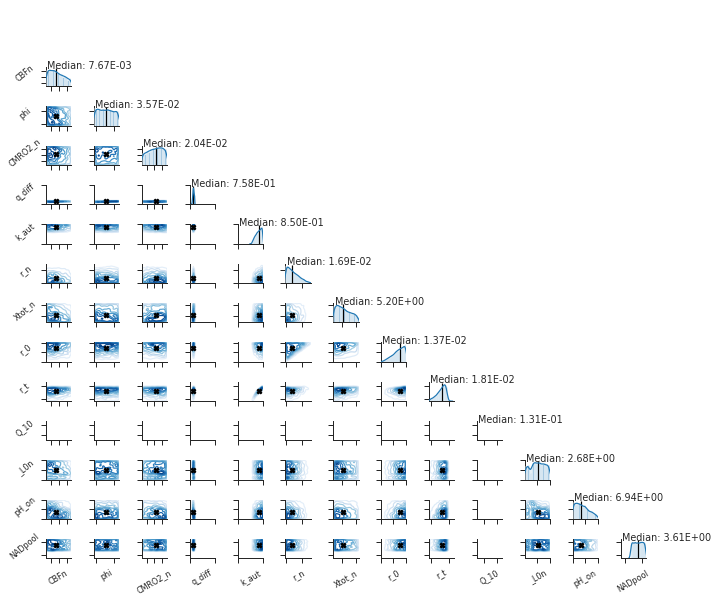

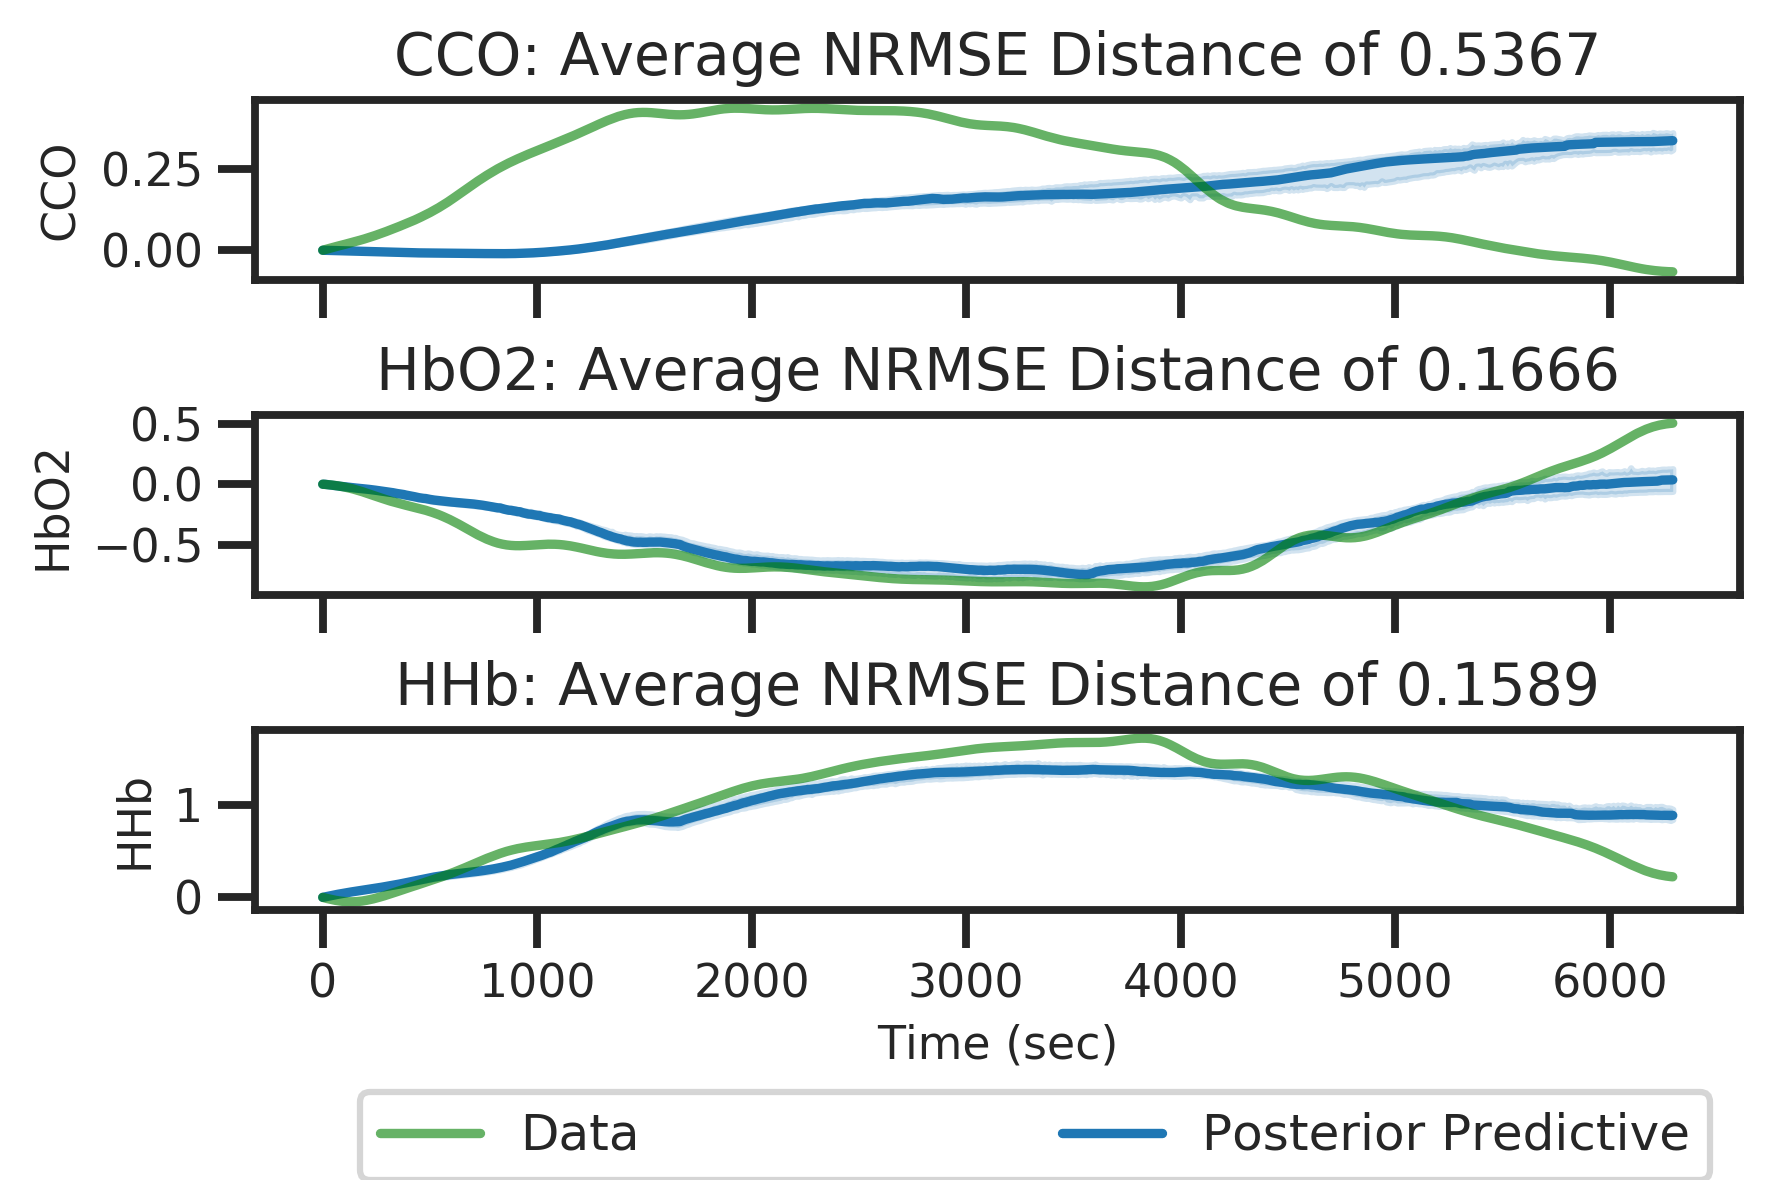

In [8]:
LIM=5000
for model_name in ['bph2_1']:
    for DATASET in ['LWP479']:#, 'LWP479' ,'LWP481' ,'LWP484']:
        print("Working on {} - {}".format(model_name, DATASET))
        # Set config and create figure path
        config = configuration[model_name][DATASET]['bayescmd_config']
        figPath = "/home/buck06191/Dropbox/phd/hypothermia/ABC/Figures/{}/{}/{}".format(model_name, DATASET, 'NRMSE')
        dir_util.mkpath(figPath)
        
        # Get posterior
        print("\tRunning SQL query")
        df_post = client.query(configuration[model_name][DATASET]['posterior_query']).to_dataframe()
        
        # Plot posterior 
        print("\tPlotting posterior")
        g = kde_plot(df_post, config['parameters'], limit=LIM, n_ticks=4, d="NRMSE", median_file=os.path.join(figPath, "medians.txt"))
        #g.fig._suptitle.set_text(g.fig._suptitle.get_text() + 'for {} - {}'.format(DATASET, model_name))
        with open(os.path.join(figPath, 'posterior_{}_{}.pickle'.format(model_name, DATASET)), 'wb') as f: 
            pickle.dump(g, f)
        g.fig.savefig(
            os.path.join(figPath, 'posterior_{}_{}.png'
                         .format(model_name, DATASET)),
            bbox_inches='tight', dpi=250)
        
        # Plot posterior predictive
        config["offset"] = {}
        print("\tPlotting Posterior Predictive")
        fig, ax, lgd = plot_repeated_outputs(df_post, n_repeats=100, limit=LIM,
                                        distance='NRMSE', **config)
        #fig.suptitle('Posterior predictive distributions\nfor {} - {}'.format(DATASET, model_name))
        #fig.set_size_inches(18.5, 12.5)
        with open(os.path.join(figPath, 'posterior_predictive_{}_{}.pickle'.format(model_name, DATASET)), 'wb') as f: 
            pickle.dump(fig, f)
        fig.savefig(
            os.path.join(figPath, 'posterior_predictive_{}_{}.png'
                         .format(model_name, DATASET)),
            bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=250)
        #plt.close('all')

In [ ]:
# fig.subplots_adjust(bottom=0.2)
# for ax in fig.axes:
#     ax.set_ylabel("$\Delta$" + ax.get_ylabel()+" ($\mu$M)")
with open(os.path.join(figPath, 'posterior_predictive_{}_{}.pickle'.format(model_name, DATASET)), 'wb') as f: 
            pickle.dump(fig, f)
fig.savefig(
    os.path.join(figPath, 'posterior_predictive_{}_{}.png'
                 .format(model_name, DATASET)),
    bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=250)

In [ ]:
# configuration = {}
# for model_number in [1, 2, 4]:
#     model_name = 'bph{}'.format(model_number)
#     configuration[model_name] = {}
#     for DATASET in ['LWP475', 'LWP479' ,'LWP481' ,'LWP484']: 
#         configuration[model_name][DATASET] = {}
#         for output in ['CCO', 'HbO2', 'HHb']:
#             configuration[model_name][DATASET][output] = {}
#             config, d0 = load_configuration(model_number, DATASET)
#             configuration[model_name][DATASET][output]['bayescmd_config'] = config
#             configuration[model_name][DATASET][output]['original_data']= d0

#             configuration[model_name][DATASET][output]['histogram_query'] = generate_histogram_query('hypothermia-bayescmd', 
#                                                                                                 DATASET, 
#                                                                                                 model_name, 
#                                                                                                 100, 
#                                                                                                 '{}_NRMSE'.format(output))

#             configuration[model_name][DATASET][output]['posterior_query'] = generate_posterior_query('hypothermia-bayescmd', 
#                                                                                                 DATASET, 
#                                                                                                 model_name, 
#                                                                                                 '{}_NRMSE'.format(output), 
#                                                                                                 list(configuration[model_name][DATASET][output]['bayescmd_config']['parameters'].keys()))


In [ ]:
# %%capture individual_outputs
# LIM=5000
# for model_name in ['bph1', 'bph2', 'bph4']:
#     for DATASET in ['LWP475', 'LWP479' ,'LWP481' ,'LWP484']:
#         for output in ['CCO', 'HbO2', 'HHb']:
#             print("Working on {} - {}, {}\n".format(model_name, DATASET, output))
#             # Set config and create figure path
#             config = configuration[model_name][DATASET][output]['bayescmd_config']
#             figPath = "/home/buck06191/Dropbox/phd/hypothermia/ABC/Figures/{}/{}/{}".format(model_name, DATASET, '{}_NRMSE'.format(output))
#             dir_util.mkpath(figPath)

#             # Get posterior
#             df_post = client.query(configuration[model_name][DATASET][output]['posterior_query']).to_dataframe()

#             # Plot posterior 
#             g = kde_plot(df_post, config['parameters'], limit=LIM, n_ticks=4, d="{}_NRMSE".format(output), median_file=os.path.join(figPath, "medians.txt"))
#             g.fig._suptitle.set_text(g.fig._suptitle.get_text() + 'for {} - {}, {}'.format(DATASET, model_name,output))
#             g.fig._suptitle.set_fontsize(26)
#             with open(os.path.join(figPath, 'posterior_{}_{}_{}.pickle'.format(model_name, DATASET,output)), 'wb') as f: 
#                 pickle.dump(g, f)
#             g.fig.savefig(
#                 os.path.join(figPath, 'posterior_{}_{}_{}.png'
#                              .format(model_name, DATASET,output)),
#                 bbox_inches='tight', dpi=250)

#             # Plot posterior predictive
#             config["offset"] = {}
#             fig, ax, lgd = plot_repeated_outputs(df_post, n_repeats=100, limit=LIM,
#                                             distance='{}_NRMSE'.format(output), **config)
#             fig.suptitle('Posterior predictive distributions\nfor {} - {}, {}'.format(DATASET, model_name,output), fontsize=26)
#             fig.set_size_inches(18.5, 12.5)
#             with open(os.path.join(figPath, 'posterior_predictive_{}_{}_{}.pickle'.format(model_name, DATASET, output)), 'wb') as f: 
#                 pickle.dump(fig, f)
#             fig.savefig(
#                 os.path.join(figPath, 'posterior_predictive_{}_{}_{}.png'
#                              .format(model_name, DATASET,output)),
#                 bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=250)
#             plt.close('all')